In [120]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%matplotlib inline

################################################################################
# Some simple plotting utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min()-1, features[:, 0].max()+1
    min2, max2 = features[:, 1].min()-1, features[:, 1].max()+1
    return (min1, max1, min2, max2)


def plot_decision_regions(
        features, targets, model,
        axis=None, transform=None,
        bounds=None,
        title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    # generate predictions over grid
    yhat = model(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)


    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(
        features[row_idx_neg, 0], features[row_idx_neg, 1],
        label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(
        features[row_idx_pos, 0], features[row_idx_pos, 1],
        label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Accuracy: 50.00%


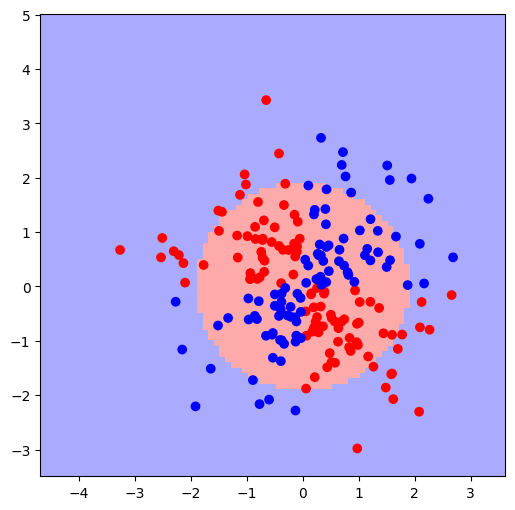

In [121]:
%pip install torch
%pip install matplotlib
%pip install numpy

import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import sys
import os
import random

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name,mode):

    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0,x1,x2])
                y_data.append([y])
                temp = [0,0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    xs = np.array(x_data,dtype='float32')
    ys = np.array(y_data,dtype='float32')
    labels = np.array(label_data,dtype='float32')
    return(xs,ys,labels)

class net3(nn.Module):
    def __init__(self,input_size,nodes,output_size):
        super(net3,self).__init__()
        self.l1 = nn.Linear(input_size,nodes)
        self.activation = nn.Sigmoid()

    def forward(self,x):
        output = self.l1(x)
        output = self.activation(output)
        a = torch.mul(x[:,1],x[:,1])
        b = torch.mul(x[:,2],x[:,2])
        c = (a+b)/9.0
        output = torch.exp(c)
        return output

def draw_example(nodes,name,model):
    x_train, y_train, label_train = read_data(name,'train')
    x_test, y_test, label_test = read_data(name,'test')
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6*(1+0)))

    h = .1  # step size in the mesh
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = np.zeros([xx.shape[0],yy.shape[1]],dtype='float32')
    Z2 = np.zeros([nodes,xx.shape[0],yy.shape[1]],dtype='float32')
    grid_data = np.ones([1,3],dtype='float32')

    grid_data2 = np.zeros([1,3],dtype='float32')
    for i in range(xx.shape[0]):
        for j in range(yy.shape[1]):
            x = xx[i,j]
            y = yy[i,j]
            grid_data2[0,0] = 1.0
            grid_data2[0,1] = x
            grid_data2[0,2] = y

            x = torch.from_numpy(grid_data2)
            pred = model(x)
            if (pred[0].item()-6.0) > -4.5:
                yh = 1.0
            else:
                yh = 0.0
            Z[i,j] = yh
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:,0], cmap=cmap_bold)


    # Calculate accuracy
    correct_predictions = 0
    total_samples = len(x_test)

    for i in range(total_samples):
        x = torch.from_numpy(x_test[i].reshape(1, -1))
        pred = model(x)
        predicted_label = 1.0 if (pred[0].item() - 6.0) > -4.5 else 0.0
        true_label = y_test[i, 0]
        if predicted_label == true_label:
            correct_predictions += 1

    accuracy = correct_predictions / total_samples
    print(f"\nAccuracy: {accuracy * 100:.2f}%")

nodes = 3
name = 'xor'
model = net3(3,nodes,1)
draw_example(nodes,name,model=model)



## FFNN with MCE

In [ ]:
%pip install torch
%pip install matplotlib
%pip install numpy
%pip install scikit-learn

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name,mode):
    features = []
    labels = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                features.append([x1,x2])
                labels.append(y)
            i = i + 1
    # return (np.array(features,dtype='float32'), np.array(labels,dtype='long'))
    return features, labels

# Define the FFNN with one hidden layer
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

def evaluate_model(model, val_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for features, labels in val_loader:
            outputs = model(features)
            if isinstance(criterion, nn.MSELoss):
                labels_one_hot = F.one_hot(labels, num_classes=output_size).float()
                loss = criterion(outputs, labels_one_hot)
            else:
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy, val_loss

def train_model(train_loader, val_loader, input_size, output_size, k_values, epochs=50, lr=0.01, criterion=nn.CrossEntropyLoss()):
    best_k = None
    best_accuracy = 0.0
    best_model = None
    best_train_losses = None
    best_val_losses = None

    for k in k_values:
        print(f"Training with {k} nodes in the hidden layer...")
        model = FFNN(input_size, k, output_size)
        optimizer = Adam(model.parameters(), lr=lr)
        train_losses = []
        val_losses = []

        # Training loop
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0.0
            for features, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(features)
                if isinstance(criterion, nn.MSELoss):
                    labels_one_hot = F.one_hot(labels, num_classes=output_size).float()
                    loss = criterion(outputs, labels_one_hot)
                else:
                    loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            # Validate the model
            val_accuracy, val_loss = evaluate_model(model, val_loader, criterion)
            train_losses.append(epoch_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}")

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_k = k
                best_model = model
                best_train_losses = train_losses
                best_val_losses = val_losses

    print(f"Best number of nodes: {best_k}, Best Validation Accuracy: {best_accuracy:.2f}")
    return best_k, best_model, best_train_losses, best_val_losses

def plot_decision_surface(model, X, y, ax=None, title="Decision Surface"):
    if ax is None:
        ax = plt.gca()
    
    # Define the grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict on the grid
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = model(grid)
    Z = torch.argmax(Z, axis=1).numpy()
    Z = Z.reshape(xx.shape)
    
    # Plot the decision surface
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=cmap_light)
    
    # Plot the training points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    
    # Add labels and title
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)
    ax.legend(*scatter.legend_elements(), title="Classes")

# Hyperparameters
k_values = [2, 3, 5, 7, 9]
epochs = 100
learning_rate = 0.01
batch_size = 32

# PyTorch-compatible dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# for dataset in datasets:
dataset = 'xor'
print(f"Processing {dataset}...")

# Use the provided read_data function to load the dataset
features_train, labels_train = read_data(dataset, 'train')  # Assuming the format is `datasetname_train.csv`
features_valid, labels_valid = read_data(dataset, 'valid')  # Assuming the format is `datasetname_train.csv`
features_test, labels_test = read_data(dataset, 'test')  # Assuming the format is `datasetname_train.csv`

print("train_labels",labels_train)

# Create DataLoaders
train_dataset = CustomDataset(features_train, labels_train)
val_dataset = CustomDataset(features_valid, labels_valid)
test_dataset = CustomDataset(features_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = 2  # Number of input features
output_size = 2  # Number of classes

# Train and find the best k
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
best_k, best_model, train_losses, val_losses = train_model(train_loader, val_loader, input_size, output_size, k_values, epochs, learning_rate, criterion)
print(f"Best number of nodes for {dataset}: {best_k}\n")

# Validate the model
val_accuracy, val_loss = evaluate_model(best_model, test_loader, criterion)
print(f"Test Accuracy: {val_accuracy:.2f}")

# Plot learning curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

# Plot decision surface 
plot_decision_surface(best_model, np.array(features_test), np.array(labels_test), title="Decision Surface")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


NameError: name 'torch' is not defined

## 3. Manual Gradients and Updates

In [ ]:
import numpy as np


def read_data(name,mode):
    features = []
    labels = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                features.append([x1,x2])
                labels.append(y)
            i = i + 1
    # return (np.array(features,dtype='float32'), np.array(labels,dtype='long'))
    return features, labels

features_train, labels_train = read_data(dataset, 'train')  # Assuming the format is `datasetname_train.csv`
features_valid, labels_valid = read_data(dataset, 'valid')  # Assuming the format is `datasetname_train.csv`
features_test, labels_test = read_data(dataset, 'test')  # Assuming the format is `datasetname_train.csv`

# 1. Define the dataset
# np.random.seed(42)
# X = np.random.rand(100, 2)  # 100 samples, 2 features
# y = (np.sum(X, axis=1) > 1).astype(float).reshape(-1, 1)  # Binary target (1 if sum > 1, else 0)

# 2. Initialize weights and biases
input_size = 2
hidden_size = 3
output_size = 2

W1 = np.random.randn(input_size, hidden_size) * 0.01  # Input to hidden weights
b1 = np.zeros((1, hidden_size))  # Hidden layer biases
W2 = np.random.randn(hidden_size, output_size) * 0.01  # Hidden to output weights
b2 = np.zeros((1, output_size))  # Output layer biases

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# 3. Forward pass
def forward(X):
    Z1 = np.dot(X, W1) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)
    return Z1, A1, Z2, A2

# 4. Loss function (Binary Cross-Entropy)
def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / m
    return loss

# 5. Backward pass
def backward(X, y, Z1, A1, Z2, A2):
    m = y.shape[0]

    # Output layer gradients
    dA2 = -(y / A2 - (1 - y) / (1 - A2))  # Derivative of loss wrt A2
    dZ2 = dA2 * sigmoid_derivative(Z2)  # Derivative of A2 wrt Z2
    dW2 = np.dot(A1.T, dZ2) / m         # Derivative of Z2 wrt W2
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m  # Derivative of Z2 wrt b2

    # Hidden layer gradients
    dA1 = np.dot(dZ2, W2.T)             # Derivative of Z2 wrt A1
    dZ1 = dA1 * sigmoid_derivative(Z1)  # Derivative of A1 wrt Z1
    dW1 = np.dot(X.T, dZ1) / m          # Derivative of Z1 wrt W1
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m  # Derivative of Z1 wrt b1

    return dW1, db1, dW2, db2

# 6. Update parameters
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr=0.01):
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    return W1, b1, W2, b2

# Training loop
epochs = 100
learning_rate = 0.01

for epoch in range(epochs):
    # Forward pass
    Z1, A1, Z2, A2 = forward(features_train)

    # Compute loss
    loss = compute_loss(np.array(labels_train), A2)

    # Backward pass
    dW1, db1, dW2, db2 = backward(np.array(features_train), np.array(labels_train), Z1, A1, Z2, A2)

    # Update parameters
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, lr=learning_rate)

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Verify with predictions
Z1, A1, Z2, A2 = forward(features_test)
predictions = (A2 > 0.5).astype(float)
accuracy = np.mean(predictions == labels_test)
print(f"Training Accuracy: {accuracy:.2f}")